In [1]:
#import packages
from PDE_FIND3 import *
from model_selection_IP3 import *
from collections import Counter
import numpy as np
import pickle
from sklearn.linear_model import Lasso
import pysindy as ps
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from scipy.integrate import odeint
from itertools import chain
import warnings
import sys
import os
warnings.filterwarnings('ignore')
from warnings import simplefilter

# arial font
import matplotlib.font_manager as fm
my_font = fm.FontProperties(fname='arial.ttc')

# Colors for each approach
color_mfld      = [216/255,27/255,96/255]
color_es        = [139/255,175/255,81/255]
color_oat       = [30/255,136/255,229/255]
color_oatinterp = [255/255,193/255,7/255]
color_data      = [0,0,0]

In [2]:
# Functions needed
def flatten_chain(matrix):
    return list(chain.from_iterable(matrix))

def f_line(x, a, b): # 'straight line' y=f(x)
    return a*x + b

def f_poly2(t,a,b,c):
    a*pow(t,2) + b*t + c
    return a*pow(t,2) + b*t + c

def f_poly3(t,a,b,c,d):
    a*pow(t,3) + b*pow(t,2) + c*t + d
    return a*pow(t,3) + b*pow(t,2) + c*t + d

def format_rp_rd(rp,rd):
    if rp==int(rp):
        rp = int(rp)
    else:
        rp = round(rp,2)
    rd = rp/2;
    if rd==int(rd):
        rd = int(rd)
    else:
        rd = round(rd,3)
    return rp,rd

def simulate_meanfield_model(t, C0, xi):
    sol = odeint(meanfield_RHS, C0, t, args=(xi,))
    return sol

def meanfield_RHS(u,t,xi):
    dudt = xi[0]*u*(1-u) - xi[1]*u
    return dudt

#ODE RHS for BDM model
def BDM_RHS(t, x, coefs,deg):
    X = np.array([x[0]**p for p in np.arange(1,deg+1)]).T
    #print(X,coefs)
    return np.matmul(X,coefs[0]) 

def BDM_RHS_eval(t, x, coefs,deg):
    X = np.array([x[0]**p for p in np.arange(1,deg+1)]).T
    #print(X,coefs)
    return np.matmul(X,coefs) # coefs instead of coefs[0]

def BDM_RHS_structure(t, x, coefs, deg):
    X = np.array([x[0]**(p+1) for p in deg]).T
    #print(X,coefs)
    return np.matmul(X,coefs)

# Forward solve the learned ODE sindy models
def BDM_solve_ODE(coeffs,degrees,rp,rd,C0):
    tf           = 20/(rp-rd)
    t_solve      = np.linspace(0, tf, 100)
    t_solve_span = (t_solve[0], t_solve[-1])
    u0_solve     = C0 #ABM[0], initial condition
    u            = solve_ivp(BDM_RHS_structure, t_solve_span, u0_solve, t_eval=t_solve, 
                             args = (coeffs,degrees)).y.T
    return(u)

# Find the least squares difference between the solved ODE and the data
def BDM_LSQ_wdata(coeffs,degrees,rp,rd,C0,data): #print(coeffs)
    u   = BDM_solve_ODE(coeffs,degrees,rp,rd,C0)
    if len(u)<100:
        return(10^7)
        print(len(u))
        print(coeffs)
        print(degrees)
        print(rp)
    lsq = LSE(u,data)
    return(lsq)

# Least squares error between data and ODE
def LSE(a,b):
    assert a.shape == b.shape
    return np.sum((a - b)**2)

# Model training function INPUTS:
    #training/testing data lists
    #optimizer with pre-defined hyperparameters
#function OUTPUTS:
    #list of sindy aic scores
    #list of weak sindy aic scores
    #list of sindy model coefficients
    #list of weak sindy model coefficients
    #note: the size of these lists equals CV_num, the number of train/test splits
def model_training_CV(optimizer,sindy_library,t_train_list,t_test_list,ABM_train_list,ABM_test_list,ABM_t_train_list,ABM_t_test_list,rp_):
    sindy_aic_list = []
    # wsindy_aic_list = []
    sindy_model_coeffs_list = []
    # wsindy_model_coeffs_list = []
    for kk in range(len(ABM_train_list)):
      ABM_train = ABM_train_list[kk]
      ABM_test = ABM_test_list[kk]
      ABM_t_train = ABM_t_train_list[kk]
      ABM_t_test = ABM_t_test_list[kk]
      t_train = t_train_list[kk]
      t_test = t_test_list[kk]

      sindy_model = ps.SINDy(feature_library=sindy_library,optimizer=optimizer)
      sindy_model.fit(ABM_train, x_dot=ABM_t_train)
      #this line is to copy the coefficients, because they will be overwritten when ps.SINDy
      #is called a second time when weak sindy is run below
      sindy_model_coeffs = sindy_model.coefficients()

      #forward solve the learned sindy model
      rp=rp_
      rd = rp/2
      tf = 20/(rp-rd)
      t_solve = np.linspace(0, tf, 100)
      t_solve_span = (t_solve[0], t_solve[-1])
      u0_solve = ABM_train[0]
      u_pred_sindy = solve_ivp(
        BDM_RHS, t_solve_span, u0_solve, t_eval=t_solve, args = (sindy_model.coefficients(),degrees)
        ).y.T
      #1d interpolation to predict the test data
      sindy_interp = interp1d(t_solve, u_pred_sindy[:,0],axis=0)
      sindy_pred_test = sindy_interp(t_test)#[:,0]
      #compute the AIC score on the test data
      sindy_sse = np.dot((sindy_pred_test[:,0]-ABM_test[:,0]),(sindy_pred_test[:,0]-ABM_test[:,0]))
      sindy_num_params = np.sum(sindy_model.coefficients()[0]!=0)
      sindy_aic = ABM_test.shape[0]*np.log(sindy_sse/ABM_test.shape[0]) + 2*sindy_num_params

      sort_train = np.argsort(t_train,axis=0)
      ABM_train = ABM_train[sort_train,0]
      ABM_t_train = ABM_t_train[sort_train,0]
      t_train = t_train[sort_train,0]

      sindy_aic_list.append(sindy_aic)
      # wsindy_aic_list.append(wsindy_aic)
      sindy_model_coeffs_list.append(sindy_model_coeffs)
      # wsindy_model_coeffs_list.append(wsindy_model_coeffs)

    return sindy_aic_list, sindy_model_coeffs_list

def find_opt_with_threshold(aic_list,old_opt,max_param_size,coeff_list,CV_nums):
  for kk in range(old_opt,len(aic_list)+1):
    num_past_thresh = 0
    for jj in range(CV_nums):
      sindy_model_coeffs = coeff_list[old_opt][jj][0]
      if np.sum(np.abs(sindy_model_coeffs)>max_param_size)>0:
        num_past_thresh+=1
    if num_past_thresh>0:
      old_opt = kk+1
    else:
      break
  return old_opt

def MSE(a,b):
    #assert a.shape == b.shape
    if a.shape != b.shape:
        return(np.nan)
    return ((a - b)**2).mean()

def convert_array_to_array_label(array):
    array_label = "$"
    for i,arr in enumerate(array):
        array_label += f"C^{arr+1}"
        if i < len(array)-1:
            array_label += f", "
        else:
            array_label += "$"
    return array_label

def ES_sindy_coefficient_values(noise, IC, drp, rp_vect):
    if noise == "nonoise":
        if IC == 0.05:
            coeff_C1_library = 0.5*rp_vect
            coeff_C2_library = -1*rp_vect
            full_coeff_library = [coeff_C1_library,
                                  coeff_C2_library]
            unified_degrees = [0,1]
        elif IC == 0.25:
            if drp == 0.01:
                coeff_C1_library =  0.49*rp_vect
                coeff_C2_library = -0.97*rp_vect
                coeff_C3_library = -0.03*rp_vect
                full_coeff_library = [coeff_C1_library,
                                      coeff_C2_library,
                                      coeff_C3_library]
                unified_degrees = [0,1,2]
            elif drp == 0.1:
                coeff_C1_library =  0.5*rp_vect
                coeff_C2_library = -0.98*rp_vect
                coeff_C3_library = -0.02*rp_vect
                full_coeff_library = [coeff_C1_library,
                                      coeff_C2_library,
                                      coeff_C3_library]
                unified_degrees = [0,1,2]
            elif drp == 0.5:
                coeff_C1_library =  0.5*rp_vect
                coeff_C2_library = -0.98*rp_vect
                coeff_C3_library = -0.02*rp_vect
                full_coeff_library = [coeff_C1_library,
                                      coeff_C2_library,
                                      coeff_C3_library]
                unified_degrees = [0,1,2]
            elif drp == 1:
                coeff_C1_library =  0.5*rp_vect
                coeff_C2_library = -1.02*rp_vect
                coeff_C3_library =  0.03*rp_vect
                full_coeff_library = [coeff_C1_library,
                                      coeff_C2_library,
                                      coeff_C3_library]
                unified_degrees = [0,1,2]
    elif noise == "lessnoise":
        if IC == 0.05:
            if drp == .01:
                coeff_C1_library =  0.5*rp_vect
                coeff_C2_library = -1.02*rp_vect
                coeff_C3_library =  0.02*rp_vect
                full_coeff_library = [coeff_C1_library,
                                      coeff_C2_library,
                                      coeff_C3_library]
                unified_degrees = [0,1,2]
            elif drp in [0.1, 0.5, 1]:
                coeff_C1_library = 0.5*rp_vect
                coeff_C2_library = -1.0*rp_vect
                full_coeff_library = [coeff_C1_library,
                                      coeff_C2_library]
                unified_degrees = [0,1]
        elif IC == 0.25:
            if drp == .01:
                coeff_C1_library =   0.5*rp_vect
                coeff_C2_library = -1.01*rp_vect
                coeff_C3_library =  0.01*rp_vect
                full_coeff_library = [coeff_C1_library,
                                      coeff_C2_library,
                                      coeff_C3_library]
                unified_degrees = [0,1,2]
            elif drp == .1:
                coeff_C1_library =   0.5*rp_vect
                coeff_C2_library = -0.98*rp_vect
                coeff_C3_library = -0.02*rp_vect
                full_coeff_library = [coeff_C1_library,
                                      coeff_C2_library,
                                      coeff_C3_library]
                unified_degrees = [0,1,2]
            elif drp == .5:
                coeff_C1_library =  0.51*rp_vect
                coeff_C2_library = -1.04*rp_vect
                coeff_C3_library =  0.05*rp_vect
                full_coeff_library = [coeff_C1_library,
                                      coeff_C2_library,
                                      coeff_C3_library]
                unified_degrees = [0,1,2]
            elif drp == 1:
                coeff_C1_library =  0.51*rp_vect
                coeff_C2_library = -1.06*rp_vect
                coeff_C3_library =  0.07*rp_vect
                full_coeff_library = [coeff_C1_library,
                                      coeff_C2_library,
                                      coeff_C3_library]
                unified_degrees = [0,1,2]
    return full_coeff_library, unified_degrees

In [3]:
# Load the data with the following set of parameters
m  = 0.05     # initial condition
num_real = 25 # number of simulation realizations
rm = 1        # migration
CV_nums = 10 # number of train/val splits

# Library and regularization parameters/set-up
#lower and upper log limits for lasso regularization parameter
lower_log = -9
upper_log = -1
#lasso settings
max_lasso_iter = 100000
#library for sindy
degrees = 10
sindy_library = ps.PolynomialLibrary(degree=degrees,include_interaction=False, include_bias=False)
#threshold for max absolute value of parameter size
max_param_size = 50

In [4]:
%%time

folder = '../../data/Data_mean_field_nonoise'
folder_save = 'pickle_data_mean_field_nonoise'
   
# Proliferation rate parameters to loop over in the EQL   
rp_vect = np.linspace(0.01,0.01,1) # np.linspace(0.01,5,500) # proliferation rate loop

for rp in rp_vect:
    # Format rp, rd for loading data
    rd = rp/2
    rp, rd = format_rp_rd(rp,rd)
   
    # Load mean-field data 
    pickle_filename = folder+'/gen_mfld_data_rp_'+str(rp)+'_rd_'+str(rd)+'_rm_'+str(rm)+'_m_'+str(m)+'.pkl'  
    with open(pickle_filename,'rb') as handle:
        data = pickle.load(handle)
    t      = data[0]
    mfld   = data[1]
    mfld_t = np.gradient(mfld,t)

    t      = np.vstack(t)
    mfld   = np.vstack(mfld)
    mfld_t = np.vstack(mfld_t)
    
    #lists to store the train/val splits
    mfld_train_list   = []
    mfld_test_list    = []
    mfld_t_train_list = []
    mfld_t_test_list  = []
    t_train_list     = []
    t_test_list      = []

    # Make many 80/20 train/val splits
    #fill the lists and keep the first and last time points in order for 1d interpolation
    #to work on the test set
    for kk in range(CV_nums):
      (mfld_train,
        mfld_test,
        mfld_t_train,
        mfld_t_test,
        t_train,
        t_test) = train_test_split(mfld[1:-1],mfld_t[1:-1],t[1:-1],train_size=.8,test_size=0.2)

      mfld_train = np.vstack([mfld[0], mfld_train, mfld[-1]])
      mfld_t_train = np.vstack([mfld_t[0], mfld_t_train, mfld_t[-1]])
      t_train = np.vstack([t[0], t_train, t[-1]])

      mfld_train_list.append(mfld_train)
      mfld_test_list.append(mfld_test)
      mfld_t_train_list.append(mfld_t_train)
      mfld_t_test_list.append(mfld_t_test)
      t_train_list.append(t_train)
      t_test_list.append(t_test)
        
    # Select the lambda with the smallest average simulation AIC
    sindy_aic_list = []
    # wsindy_aic_list = []
    sindy_model_coeffs_list = []
    # wsindy_model_coeffs_list = []

    for lmb in np.logspace(lower_log,upper_log,100):
      optimizer = Lasso(alpha=lmb, max_iter=max_lasso_iter, fit_intercept=False)
      sindy_aic, sindy_model_coeffs = model_training_CV(optimizer,sindy_library,t_train_list,t_test_list,mfld_train_list,mfld_test_list,mfld_t_train_list,mfld_t_test_list,rp_=rp)
      sindy_aic_list.append(np.mean(sindy_aic))
      sindy_model_coeffs_list.append(sindy_model_coeffs)

    #indices of the lasso regulatization parameter where the lowest AIC scores occur
    sindy_opt  = np.argmin(sindy_aic_list)
    sindy_opt  = find_opt_with_threshold(sindy_aic_list,sindy_opt,max_param_size,sindy_model_coeffs_list,CV_nums)

    ############ Most popular learned model
    # Extract most popular learned model coefficients: SINDy
    xi_list = sindy_model_coeffs_list[sindy_opt]
    xi_vote = [[] for d in np.arange(len(xi_list))]

    # Extract how many times each model is learned in the test/train splits
    xi_vote_tmp = []
    for j in range(len(xi_list)):
        xi_vote_tmp.append(trans_rev((np.abs(xi_list[j][0]) > 1e-4)*1))
    num_eqns = 3
    xi_vote_tmp = Counter(xi_vote_tmp).most_common(num_eqns)
    xi_vote = [x[0] for x in xi_vote_tmp]

    # Set up for bookkeeping for obtaining mean param estimates
    matrix_vote_initialized = False
    A = [""]

    #loop through coefficient estimates and extract those corresponding to the most popular model
    for j in np.arange(len(xi_list)):
        xi_full = xi_list[j]
        match =  trans_rev(np.abs(xi_full[0]) > 1e-4 )*1 == xi_vote[0]
        if np.any(match):
            if not matrix_vote_initialized:
                A[0] = xi_full
                matrix_vote_initialized = True
            else:
                A[0] = np.vstack((A[0],xi_full))

    # Save mean coefficients for the most popular equation
    xi_vote_params_sindy = np.mean(A[0],axis=0)
    print(xi_vote_params_sindy)

    # Final mean learned coefficients from (weak)SINDy
    final_sindy_coeffs  = xi_vote_params_sindy

    # Parameters/set-up for forward solving the learned sindy models
    tf = 20/(rp-rd)  # final time
    t_solve = np.linspace(0, tf, 100)
    t_solve_span = (t_solve[0], t_solve[-1])
    C0 = mfld[0] # the initial condition

    # Forward solve with these mean learned coefficients
    u_pred_sindy = solve_ivp(
          BDM_RHS_eval, t_solve_span, C0, t_eval=t_solve, args = (final_sindy_coeffs,degrees)
          ).y.T

    # Use mean learned coefficients as guesses for parameter estimation with final model structure
    degs_sindy   = np.nonzero(final_sindy_coeffs)[0]
    coeffs_sindy = final_sindy_coeffs[degs_sindy]
    init_coeffs  = coeffs_sindy  # initial guess
    res          = minimize(BDM_LSQ_wdata,init_coeffs, method='nelder-mead',
                   args=(degs_sindy,rp,rd,C0,mfld), options={'xatol': 1e-8, 'disp': True,'maxfun':10**5})
    coeffs_sindy_opt = res.x
    u_opt_sindy  = BDM_solve_ODE(coeffs_sindy_opt,degs_sindy,rp,rd,C0)

    # # Save data in pickle format
    # import pickle
    # pickle_filename = folder_save + '/eql_mfld_coeffs_rp_'+str(rp)+'_rd_'+str(rd)+'_rm_'+str(rm)+'_m_'+str(m)+'_real25.pkl'
    # with open(pickle_filename, 'wb') as h:
    #         pickle.dump([coeffs_sindy_opt,t_solve,u_opt_sindy,
    #                      degs_sindy,
    #                      final_sindy_coeffs,u_pred_sindy,
    #                      sindy_aic_list,sindy_opt],h,protocol=pickle.HIGHEST_PROTOCOL)

print(coeffs_sindy_opt)
print(degs_sindy)

[ 0.0049979  -0.00999554  0.          0.          0.          0.
  0.          0.          0.          0.        ]
Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 39
         Function evaluations: 74
[ 0.00499781 -0.00999563]
[0 1]
CPU times: total: 8.97 s
Wall time: 9.23 s


Text(0, 0.5, '$\\mathrm{Population\\ density\\ \\it{C(t)}}$')

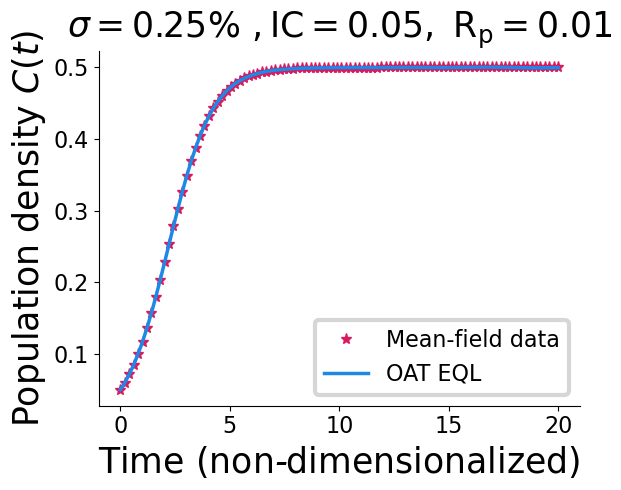

In [5]:
# Example fit with OAT EQL
m       = 0.05     # initial condition
degrees = 10

# Parameter set-up
folder = '../../data/Data_mean_field_nonoise'

rm     = 1
rp     = 0.01
rd     = rp/2
# Parameters/set-up for forward solving the learned sindy models
tf = 20/(rp-rd)  # final time
t_solve = np.linspace(0, tf, 100)
t_solve_span = (t_solve[0], t_solve[-1])

# Mean-field coefficients
coeff_C1_mfld = rp/2
coeff_C2_mfld = -rp

# Format rp, rd for loading data
rp, rd = format_rp_rd(rp,rd)

# Load mean-field data 
pickle_filename = folder+'/gen_mfld_data_rp_'+str(rp)+'_rd_'+str(rd)+'_rm_'+str(rm)+'_m_'+str(m)+'.pkl'  
with open(pickle_filename,'rb') as handle:
    data = pickle.load(handle)
t      = data[0]
mfld   = data[1]

# Load EQL results
pickle_filename = folder_save+'/eql_mfld_coeffs_rp_'+str(rp)+'_rd_'+str(rd)+'_rm_'+str(rm)+'_m_'+str(m)+'_real25.pkl'  
with open(pickle_filename,'rb') as handle:
    data = pickle.load(handle)
coeffs_sindy_opt  = data[0]
degs_sindy        = data[3]

# Construct full coefficient vectors
coeff_full_sindy  = np.zeros(10)
for l in range(len(degs_sindy)):
    coeff_full_sindy[degs_sindy[l]] = coeffs_sindy_opt[l]

# Forward solve with the original learned coefficients
C0 = [m]
u_sindy = solve_ivp(BDM_RHS_eval, t_solve_span, C0, t_eval=t_solve, args = (coeff_full_sindy,degrees)).y.T
u_sindy = np.array(flatten_chain(u_sindy))

# Forward solve with mean-field coefficients
xi_mfld  = [rp,rd]
sol_mfld = simulate_meanfield_model(t,m,xi_mfld)
u_mfld   = np.array(flatten_chain(sol_mfld))

### Plotting
fontsize = 25
plt.rc('axes', labelsize=16)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('axes', titlesize=16)

t_solve_nondim = t_solve*(rp-rd)
fig, ax = plt.subplots(1, 1, figsize=(6,5), tight_layout=True)
ax.plot(t_solve_nondim,mfld,'*',label = "Mean-field data", color=color_mfld, markersize=8)
ax.plot(t_solve_nondim,u_sindy,label = "OAT EQL", color=color_oat, linewidth=2.5)
# ax.plot(t_solve_nondim,u_library,label = "ES EQL", color=color_es, linewidth=2.5)
# legend
legend = plt.legend(loc='best',fontsize=16)
frame = legend.get_frame()
frame.set_linewidth(3) 
# box off
for pos in ['top', 'right']:
    ax.spines[pos].set_visible(False)
ax.set_title("$\sigma = \mathrm{" +str(0.25) +"\% \ , IC =  " + str(m) + ", \ R_p=" + str(rp) +"}$",fontproperties=my_font,fontsize=fontsize)
ax.set_xlabel("$\mathrm{Time\ (non}$-$\mathrm{dimensionalized)}$",fontproperties=my_font,fontsize=fontsize)
ax.set_ylabel("$\mathrm{Population\ density\ \it{C(t)}}$",fontproperties=my_font,fontsize=fontsize)

In [6]:
# Extract learned coefficients from OAT EQL analysis
m       = 0.05     # initial condition
rm      = 1        # migration
rp_vect = np.linspace(0.01,5,500)

noise = 'nonoise'
sigma = 0
# noise = 'lessnoise'
# sigma = 0.25

folder = 'pickle_data_mean_field_' + noise 

lower_log = -9 # range for lambda
upper_log = -1
lmb_range = np.logspace(lower_log,upper_log,100)

coeff_C1_sindy = []
coeff_C2_sindy = []
coeff_C3_sindy = []
coeff_C4_sindy = []
coeff_C5_sindy = []
coeff_C6_sindy = []
coeff_C7_sindy = []
coeff_C8_sindy = []
coeff_C9_sindy = []
coeff_C10_sindy = []
degs_sindy_vect = []
degs_sindy_all  = []
lmb_opt_all     = []

# max degree across parameters
max_sindy  = 0

for rp in rp_vect:
    rp, rd = format_rp_rd(rp,rd)

    # Load learned coefficients
    pickle_filename = folder+'/eql_mfld_coeffs_rp_'+str(rp)+'_rd_'+str(rd)+'_rm_'+str(rm)+'_m_'+str(m)+'_real25.pkl'
    with open(pickle_filename,'rb') as handle:
        data = pickle.load(handle)
    coeffs_sindy_opt  = data[0]
    degs_sindy        = data[3]
    sindy_opt         = data[7]

    lmb_opt = lmb_range[sindy_opt]

    degs_sindy_all.append(np.array(degs_sindy))
    lmb_opt_all.append(np.array(lmb_opt))

    if np.max(degs_sindy)>max_sindy:
        max_sindy = np.max(degs_sindy)

    # Construct full coefficient vectors
    coeff_full_sindy  = np.zeros(10)
    for l in range(len(degs_sindy)):
        coeff_full_sindy[degs_sindy[l]] = coeffs_sindy_opt[l]

    coeff_C1_sindy.append(coeff_full_sindy[0])
    coeff_C2_sindy.append(coeff_full_sindy[1])
    coeff_C3_sindy.append(coeff_full_sindy[2])
    coeff_C4_sindy.append(coeff_full_sindy[3])
    coeff_C5_sindy.append(coeff_full_sindy[4])
    coeff_C6_sindy.append(coeff_full_sindy[5])
    coeff_C7_sindy.append(coeff_full_sindy[6])
    coeff_C8_sindy.append(coeff_full_sindy[7])
    coeff_C9_sindy.append(coeff_full_sindy[8])
    coeff_C10_sindy.append(coeff_full_sindy[9])
    degs_sindy_vect.append(np.max(degs_sindy)+1)

indices = [i for i, x in enumerate(degs_sindy_vect) if x == 2]
indices =  np.array(indices)

print("Max sindy degree:")
print(max_sindy+1) # because indices start at 0

# Coefficients learned: ES ME-EQL approach
n = 500 # number of samples used
if noise == 'nonoise':
    coeff_C1_library = 0.5*rp_vect
    coeff_C2_library = -1*rp_vect
elif noise == 'lessnoise':
    coeff_C1_library = 0.5*rp_vect
    coeff_C2_library = -1.02*rp_vect
    coeff_C3_library = 0.02*rp_vect
elif noise == 'morenoise':
    coeff_C1_library = 0.5*rp_vect
    coeff_C2_library = -0.99*rp_vect
    coeff_C4_library = -0.29*rp_vect    
    coeff_C5_library = 0.5*rp_vect   

Max sindy degree:
3


Text(0, 0.5, '$\\mathrm{Coefficients}$')

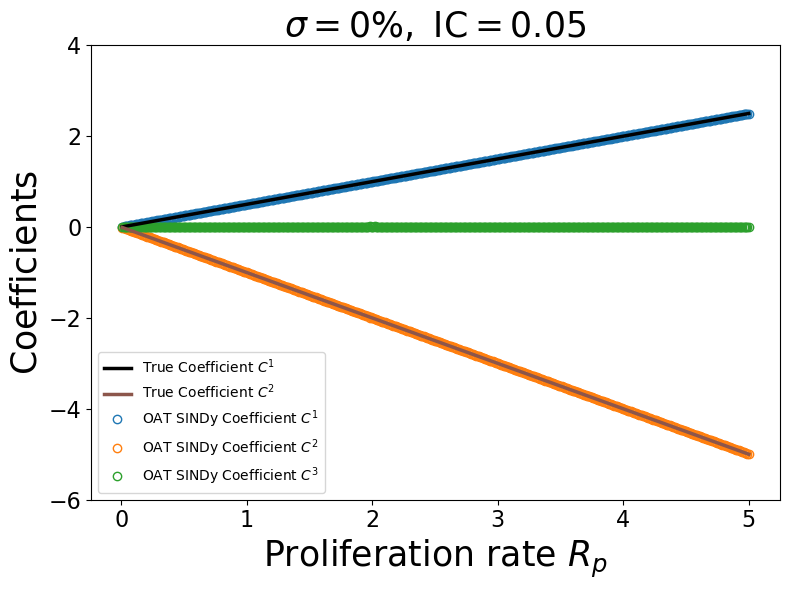

In [7]:
# Visualize coefficients learned from OAT EQL
plt.rc('axes', labelsize=16)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('axes', titlesize=16)
fig, ax = plt.subplots(1, 1, figsize=(8,6), tight_layout=True) 
# True coefficients
ax.plot(rp_vect,0.5*rp_vect,"-",color='black',linewidth = 2.5,label = "True Coefficient $C^1$",zorder=10)
ax.plot(rp_vect,-1*rp_vect,"-",color='tab:brown',linewidth = 2.5,label = "True Coefficient $C^2$",zorder=10)
# OAT coefficients
ax.plot(rp_vect,coeff_C1_sindy,"o",markerfacecolor='none', markeredgewidth=1,label = "OAT SINDy Coefficient $C^1$") 
ax.plot(rp_vect,coeff_C2_sindy,"o",markerfacecolor='none', markeredgewidth=1,label = "OAT SINDy Coefficient $C^2$")
ax.plot(rp_vect,coeff_C3_sindy,"o",markerfacecolor='none', markeredgewidth=1,label = "OAT SINDy Coefficient $C^3$")
if noise == 'lessnoise':
    ax.plot(rp_vect,coeff_C4_sindy,"o",markerfacecolor='none', markeredgewidth=1,label = "OAT SINDy Coefficient $C^4$") 
    ax.plot(rp_vect,coeff_C5_sindy,"o",markerfacecolor='none', markeredgewidth=1,label = "OAT SINDy Coefficient $C^5$")
    ax.plot(rp_vect,coeff_C6_sindy,"o",markerfacecolor='none', markeredgewidth=1,label = "OAT SINDy Coefficient $C^6$")

# legend
ax.legend(loc='best')
ax.set_ylim([-6, 4])
ax.set_title("$\sigma=\mathrm{" + str(sigma) +'\%, \ IC=' + str(m) +"}$",fontproperties=my_font,fontsize=fontsize)
ax.set_xlabel("$\mathrm{Proliferation\ rate\ \it{R_p}}$",fontproperties=my_font,fontsize=fontsize)
ax.set_ylabel("$\mathrm{Coefficients}$",fontproperties=my_font,fontsize=fontsize)


Text(0, 0.5, '$\\mathrm{Coefficients}$')

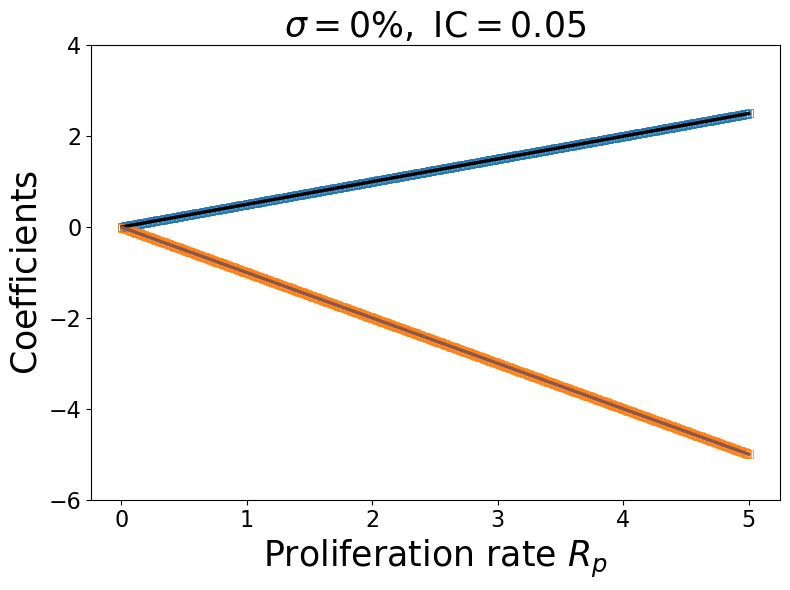

In [8]:
# Visualize coefficients learned using ES ME-EQL
plt.rc('axes', labelsize=16)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('axes', titlesize=16)
fig, ax = plt.subplots(1, 1, figsize=(8,6), tight_layout=True) #figsize= (9,8) when we have the legend in
# True coefficients
ax.plot(rp_vect,0.5*rp_vect,"-",color='black',linewidth = 2.5,label = "True Coefficient $C^1$",zorder=10)
ax.plot(rp_vect,-1*rp_vect,"-",color='tab:brown',linewidth = 2.5,label = "True Coefficient $C^2$",zorder=10)
# ES coefficients
ax.plot(rp_vect,coeff_C1_library,"s",markerfacecolor='none', markeredgewidth=0.5,label = "ES SINDy Coefficient $C^1$")
ax.plot(rp_vect,coeff_C2_library,"s",markerfacecolor='none', markeredgewidth=0.5,label = "ES SINDy Coefficient $C^2$")
if noise == 'lessnoise':
    ax.plot(rp_vect,coeff_C3_library,"s",markerfacecolor='none', markeredgewidth=0.5,label = "ES SINDy Coefficient $C^3$")
    
ax.set_ylim([-6, 4])
ax.set_title("$\sigma=\mathrm{" + str(sigma) +'\%, \ IC=' + str(m) +"}$",fontproperties=my_font,fontsize=fontsize)
ax.set_xlabel("$\mathrm{Proliferation\ rate\ \it{R_p}}$",fontproperties=my_font,fontsize=fontsize)
ax.set_ylabel("$\mathrm{Coefficients}$",fontproperties=my_font,fontsize=fontsize)


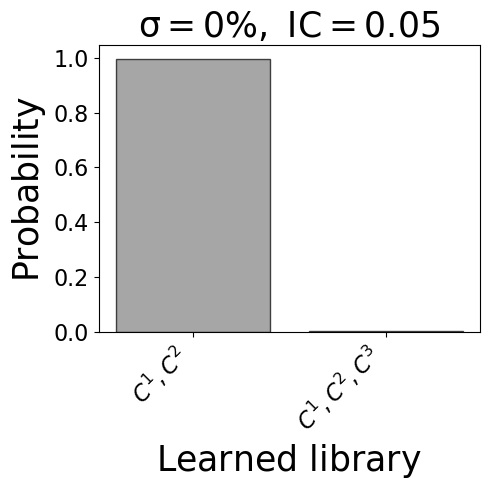

In [15]:
# Visualize frequency/probability of learned models
# Convert arrays to tuples to make them hashable
hashable_data = [tuple(arr) for arr in degs_sindy_all]

# Count the frequency of each unique array
frequency_count = Counter(hashable_data)

# Extract unique arrays and their frequencies
unique_arrays = list(frequency_count.keys())
frequencies = list(frequency_count.values())

unique_arrays_tmp = []
for array in unique_arrays:
    array_tmp = [int(arr) for arr  in array]
    unique_arrays_tmp.append(array_tmp)
unique_arrays = unique_arrays_tmp

# Prepare data for the histogram
labels = [convert_array_to_array_label(array) for array in unique_arrays]

# Convert frequencies to probabilities
total = np.sum(frequencies)
probabilities = frequencies / total  # Normalize to sum to 1

### sort lowest to highest
sorting_indices = np.argsort(probabilities)
### sort highest to lowest
sorting_indices = sorting_indices[::-1]
### sort probabilities and labels
probabilities_sorted = probabilities[sorting_indices]
labels_sorted = [labels[ind] for ind in sorting_indices]

# Plot the histogram
plt.rc('axes', labelsize=16)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('axes', titlesize=16)
fig, ax = plt.subplots(1, 1, figsize=(5,5), tight_layout=True)
plt.bar(labels_sorted, probabilities_sorted, color='grey', alpha=0.7, edgecolor='black')

# Add labels and title
plt.xlabel('$\mathrm{Learned\ library}$',fontproperties=my_font,fontsize=fontsize)
plt.ylabel('$\mathrm{Probability}$',fontproperties=my_font,fontsize=fontsize)
plt.title('$\mathrm{Distribution\ of\ OAT\ ME-EQL\n learned\ equations,\n \sigma=' + str(sigma) +'\%,\ IC=' + str(m)+"}$",fontproperties=my_font,fontsize=fontsize)
plt.title('$\mathrm{\sigma=' + str(sigma) +'\%,\ IC=' + str(m)+"}$",fontproperties=my_font,fontsize=fontsize)
#plt.title("$\mathrm{Distribution\ of\ OAT\ ME-EQL" +"}$" + "$\mathrm{\n learned\ equations,}$" ,fontproperties=my_font,fontsize=fontsize)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()

In [16]:
# Set up OAT ME-EQL interpolation
drp  = 1 # delta Rp between data points considered for training; options: 0.01, 0.5 or 1 
evry = round(drp/0.01)
rp_sparse   = np.arange(0.01,5,drp)
rp_sparse_orig = rp_sparse
inds_sparse = np.arange(0,500,evry)
n = len(rp_vect[inds_sparse])
print(n)
degs_sindy_sparse = [degs_sindy_all[i] for i in inds_sparse]
print(degs_sindy_sparse[0])

# Set-up to fit coefficients with lines
target = degs_sindy_sparse[0] 
indices_temp = [i for i, value in enumerate(degs_sindy_sparse) if np.array_equal(value,target)]
inds_sparse_temp = inds_sparse[indices_temp]
print(len(inds_sparse_temp))
inds_sparse = inds_sparse_temp

# Take sparse selection of indices and fit
rp_sparse   = rp_vect[inds_sparse]
coeff_C1_sparse = [coeff_C1_sindy[i] for i in inds_sparse]
coeff_C2_sparse = [coeff_C2_sindy[i] for i in inds_sparse]

# Line fit
# Fit coefficients C^1
popt, pcov       = curve_fit(f_line,rp_sparse,coeff_C1_sparse) # data x, y to fit
coeff_C1_fit     = f_line(np.array(rp_sparse), *popt)
coeff_C1_fitfull = f_line(np.array(rp_vect), *popt)
print(popt)

# Fit coefficients C^2
popt, pcov       = curve_fit(f_line,rp_sparse,coeff_C2_sparse) # data x, y to fit
coeff_C2_fit     = f_line(np.array(rp_sparse), *popt)
coeff_C2_fitfull = f_line(np.array(rp_vect), *popt)
print(popt)

5
[0 1]
5
[ 4.99774772e-01 -1.32714823e-04]
[-9.99547734e-01  2.97075099e-04]


In [17]:
# Coefficients from ES ME-EQL approach
full_coeff_library, unified_degrees = ES_sindy_coefficient_values(noise, m, drp, rp_vect)
coeff_C1_library = full_coeff_library[0]
coeff_C2_library = full_coeff_library[1]
if len(full_coeff_library) == 3:
    coeff_C3_library = full_coeff_library[2]

In [18]:
# Calculate MSE error with coefficients from interpolated curves
mse_sindy   = np.zeros(len(rp_vect))
mse_interp  = np.zeros(len(rp_vect))
mse_library = np.zeros(len(rp_vect))
mse_mfld    = np.zeros(len(rp_vect))
folder1 = '../../data/Data_mean_field_'+ noise
folder2 = 'pickle_data_mean_field_'+noise

for j in indices: 
    
    rp = rp_vect[j]
    rd = rp_vect/2 
    rp, rd = format_rp_rd(rp,rd)
        
    # Load mean-field generated data   
    pickle_filename = folder1+'/gen_mfld_data_rp_'+str(rp)+'_rd_'+str(rd)+'_rm_'+str(rm)+'_m_'+str(m)+'.pkl'  
    with open(pickle_filename,'rb') as handle:
        data = pickle.load(handle)
    t            = data[0]
    mfldpnoise   = data[1]
 
    # Parameters/set-up for forward solving the learned sindy models
    tf      = 20/(rp-rd)  # final time
    t_solve = np.linspace(0, tf, 100)
    t_solve_span = (t_solve[0], t_solve[-1])
    C0 = m # the initial condition

    # Load EQL results
    pickle_filename = folder2+'/eql_mfld_coeffs_rp_'+str(rp)+'_rd_'+str(rd)+'_rm_'+str(rm)+'_m_'+str(m)+'_real25.pkl'  
    with open(pickle_filename,'rb') as handle:
        data = pickle.load(handle)
    coeffs_sindy_opt  = data[0]
    degs_sindy        = data[3]
    
    # Construct full coefficient vectors
    coeff_full_sindy  = np.zeros(10)
    for l in range(len(degs_sindy)):
        coeff_full_sindy[degs_sindy[l]] = coeffs_sindy_opt[l]

    # Forward solve with the original learned coefficients
    C0 = [C0]
    u_sindy = solve_ivp(BDM_RHS_eval, t_solve_span, C0, t_eval=t_solve, args = (coeff_full_sindy,degrees)).y.T
    u_sindy = np.array(flatten_chain(u_sindy))

    # Forward solve with interpolated coefficients
    coeff_interp = [coeff_C1_fitfull[j],coeff_C2_fitfull[j]] 
    # Construct full coefficient vector
    coeff_full_interp  = np.zeros(10)
    degs_interp = [0,1] # i.e., degress C^1, C^2
    for l in range(len(degs_interp)):
        coeff_full_interp[degs_interp[l]] = coeff_interp[l]
    u_interp = solve_ivp(BDM_RHS_eval, t_solve_span, C0, t_eval=t_solve, args = (coeff_full_interp,degrees)).y.T
    u_interp = np.array(flatten_chain(u_interp))

    # Forward solve with coefficients from the library learning
    if len(full_coeff_library)==2:
        coeff_library = [coeff_C1_library[j],coeff_C2_library[j]] 
    else:
        coeff_library = [coeff_C1_library[j],coeff_C2_library[j],coeff_C3_library[j]] 
    # Construct full coefficient vector
    coeff_full_library  = np.zeros(10)
    degs_library = unified_degrees 
    for l in range(len(degs_library)):
        coeff_full_library[degs_library[l]] = coeff_library[l]
    u_library = solve_ivp(BDM_RHS_eval, t_solve_span, C0, t_eval=t_solve, args = (coeff_full_library,degrees)).y.T
    u_library = np.array(flatten_chain(u_library))

    # Forward solve with mean-field coefficients
    xi_mfld  = [rp,rd]
    sol_mfld = simulate_meanfield_model(t,m,xi_mfld)
    u_mfld   = np.array(flatten_chain(sol_mfld))

    mse_sindy[j]   = MSE(mfldpnoise,u_sindy) # MSE between data and ODE solution with original learned coefficients
    mse_interp[j]  = MSE(mfldpnoise,u_interp) # MSE between data and ODE solution with coefficients interpolated
    mse_library[j] = MSE(mfldpnoise,u_library) # MSE between data and ODE solution with library coefficients (fewer data)
    mse_mfld[j]    = MSE(mfldpnoise,u_mfld) # MSE between data and ODE solution with library coefficients (fewer data)

mse_sindy_sparse = mse_sindy[inds_sparse]

Text(0, 0.5, '$\\mathrm{MSE}$')

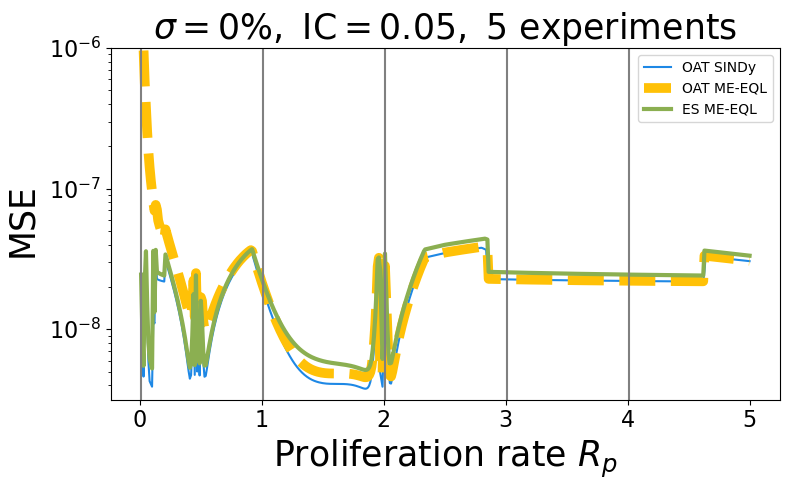

In [19]:
# Plot MSEs of fits from sparsification experiments
plt.rc('axes', labelsize=16)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('axes', titlesize=16)

fig, ax = plt.subplots(1, 1, figsize=(8,5), tight_layout=True)
ax.plot(rp_vect[indices],mse_sindy[indices],color = color_oat,label = "OAT SINDy")
ax.plot(rp_vect[indices],mse_interp[indices],'--',color = color_oatinterp,label = "OAT ME-EQL", linewidth=7)
ax.plot(rp_vect[indices],mse_library[indices],color = color_es,label = "ES ME-EQL", linewidth=3)
if noise == 'lessnoise':
    ax.plot(rp_vect[indices],mse_mfld[indices],'--',color = color_mfld,label = "True mean-field data", linewidth=3)
if noise == 'nonoise':
    ax.vlines(rp_sparse,10**(-8.5), 10**(-6),colors = 'grey',linestyles='solid')
elif noise == 'lessnoise':
    ax.vlines(rp_sparse,10**(-6.2), 10**(-5),colors = 'grey',linestyles='solid')
rp_sparse_filtered = list(set(rp_sparse_orig)-set(rp_sparse))
if noise == 'nonoise':
    ax.vlines(rp_sparse_filtered,10**(-8.5), 10**(-6),colors = 'grey',linestyles=(0, (5, 10)))
elif noise == 'lessnoise':
    ax.vlines(rp_sparse_filtered,10**(-6.2), 10**(-5),colors = 'grey',linestyles=(0, (5, 10)))
# legend
ax.legend(loc='best')
ax.set_title("$\sigma=\mathrm{"+str(sigma)+'\%,\ IC='+ str(m) + ",\ " + str(n) + "\ experiments}$",fontproperties=my_font,fontsize=fontsize)
if noise == 'nonoise':
    ax.set_ylim([10**(-8.5), 10**(-6)])
elif noise == 'lessnoise':
    ax.set_ylim([10**(-6.2), 1.1*10**(-5)])
ax.set_yscale('log')
ax.set_xlabel("$\mathrm{Proliferation\ rate\ \it{R_p}}$",fontproperties=my_font,fontsize=fontsize)
ax.set_ylabel("$\mathrm{MSE}$",fontproperties=my_font,fontsize=fontsize)